In [1]:
from sqlalchemy import create_engine
import pandas as pd
from dotenv import load_dotenv
import os

# 환경 변수 불러오기
load_dotenv()
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
database = os.getenv('DB_NAME')

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{database}")

videos_df = pd.read_sql("SELECT * FROM video", engine)
channels_df = pd.read_sql("SELECT * FROM channel", engine)

merged_df = pd.merge(videos_df, channels_df, on='channelID', how='left')

merged_df.head()

,videoID,categoryID,channelID,title,viewCount,likeCount,commentCount,uploadDate,duration,tags,thumbnailURL,keyword,token_tagging,channelTitle,subscriberCount,totalViews,videosCount
0,--0-PnOg3yk,4,UCyd3fS5bslY4euLHMvACKwA,2025 개막전 예매일정! #9up #야구 #kbo #프로야구,705,9,0,2025-03-08 06:00:00,38,[],https://i.ytimg.com/vi/--0-PnOg3yk/hqdefault.jpg,일정,"[('2025', 'Number'), ('개막전', 'Noun'), ('예매', '...",9UP 프로야구,544,1252489,206
1,--0Ql-Wv0TE,10,UCArzt7z59exy6-9t-SKUtMA,젊은 중년 여성들을 위한 데이트 팁과 노하우 5가지 #중년여자 #중년여성 #데이트,447,5,0,2025-03-16 08:00:00,60,"['중년여성', '중년여자', '데이트', 'shorts']",https://i.ytimg.com/vi/--0Ql-Wv0TE/hqdefault.jpg,팁,"[('젊은', 'Adjective'), ('중년', 'Noun'), ('여성', '...",이서희경제연구所,1140,256305,376
2,--3C_neCk_8,10,UC68lpQQFiY4EH22L66C3FoQ,# 깜찍한 폰케이스 언박싱📱💕,110,9,2,2025-03-16 09:58:18,60,[],https://i.ytimg.com/vi/--3C_neCk_8/hqdefault.jpg,언박싱,"[('#', 'Punctuation'), ('깜찍한', 'Adjective'), (...",# 슈빈,332,746,4
3,--3kZm7wt3I,10,UC3AqIjI0HmzCRfVegGjgeNQ,태국에서 스마트폰 가격이 한국의 2배인 이유,1385,9,0,2025-03-19 05:38:52,37,"['국제커플', '한태커플', '태국일상', '한일커플', '한중커플', '여행유튜...",https://i.ytimg.com/vi/--3kZm7wt3I/hqdefault.jpg,스마트폰,"[('태국', 'Noun'), ('에서', 'Josa'), ('스마트폰', 'Nou...",평범한남 최씨 [여행] Ordinary Korean Guy,32500,13645479,837
4,--6q2FHApro,1,UC1_cD5so-OXfGRWRhT9Wabw,2025.3.7 라이브편집~ 친구와서 사우나도 가고 갈비도 먹고 소주도 먹고 마...,595,4,6,2025-03-11 11:55:02,3796,[],https://i.ytimg.com/vi/--6q2FHApro/hqdefault.jpg,라이브,"[('2025.3', 'Number'), ('.', 'Punctuation'), (...",황진이tv,2650,336258,485


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 사용할 피처 선택
features = [
    'subscriberCount', 'videosCount', 'duration',
    'likeCount', 'commentCount', 'categoryID'
]

# 결측치 제거 및 필요한 열만 추출
df = merged_df[features + ['viewCount']].dropna()

# 입력 X, 타겟 y 설정
X = df[features]
y = df['viewCount']

# 로그 변환
y_log = np.log1p(y)

# 학습용/테스트용 분리
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train_log)

# 예측
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # 로그 역변환
y_test = np.expm1(y_test_log)

# 평가 지표 출력
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

RMSE: 210341.67
R² Score: 0.6610


In [3]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

# 특성과 타겟 준비
features = [
    'subscriberCount', 'videosCount', 'duration',
    'likeCount', 'commentCount', 'categoryID'
]
df = merged_df[features + ['viewCount']].dropna()

X = df[features]
y = np.log1p(df['viewCount'])  # 로그 변환

# 학습/테스트 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 훈련
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# RMSE 계산 (로그 스케일 기준)
mse_log = mean_squared_error(y_test, y_pred)
rmse_log = np.sqrt(mse_log)

# R² (로그 스케일 기준)
r2_log = r2_score(y_test, y_pred)

print(f"로그 스케일 기준 평가")
print(f"RMSE (log1p): {rmse_log:.4f}")
print(f"R² Score (log1p): {r2_log:.4f}")

로그 스케일 기준 평가
RMSE (log1p): 1.0202
R² Score (log1p): 0.8892


In [4]:
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

gap = y_test_exp - y_pred_exp

result_df = X_test.copy()
result_df['actual_viewCount'] = y_test_exp
result_df['predicted_viewCount'] = y_pred_exp
result_df['gap'] = gap

sorted_df = result_df.sort_values(by='gap', ascending=False)

threshold = sorted_df['subscriberCount'].quantile(0.3)
low_sub_df = sorted_df[sorted_df['subscriberCount'] <= threshold]

test_indices = y_test.index
test_originals = merged_df.loc[test_indices]

original_info = merged_df.loc[low_sub_df.index]

low_sub_df = low_sub_df.copy()
low_sub_df['videoID'] = original_info['videoID'].values
low_sub_df['title'] = original_info['title'].values
low_sub_df['channelTitle'] = original_info['channelTitle'].values
low_sub_df['keyword'] = original_info['keyword'].values

final_df = low_sub_df[[
    'videoID', 'title', 'channelTitle', 'subscriberCount',
    'actual_viewCount', 'predicted_viewCount', 'gap'
]]

# 상위 30개 결과 보기
print(final_df.sort_values(by='gap', ascending=False).head(30))

           videoID                                              title  \
40656  H8CZ9z0t9Kw                                한국 음악/영화/뮤지컬 시상식 차이   
98629  Z41ZnD9lDRw                    4,500원 투썸 신상 초코요거트아이스크림 #투썸플레이스   
47144  j8sBFibgRqA             할아버지가 목사님이라면? #아기쇼츠 #10개월아기 #크리스천연애와결혼   
84016  uL11pjTZ90I  "허각님을 시부야에서 봤다고 하면 믿을 사람?ㅋㅋㅋ" #일본여행 #여행 #구독 #좋...   
28951  DK5vYFrJKPo                             일본 맛집의 진실, 한국도 그렇게 될까?   
72455  qYwAZzb0K9I                           구마유시가 솔랭에서 만난 요네의 슈퍼 플레이   
41114  HDWqP0nznjc                                      진격의거인 리바이 명장면   
51067  KfqvqNj4tZI                     2025년 랜덤 플레이 댄스 #랜플댄 #첫영상 #많관부   
86869  Vh5fVR9jci8  역대급 커버 메이크업!✨#makeup #covermakeup #커버메이크업 #흉터커...   
39411  GsXIUKHx0aM  단골 손님의 의문의 얼음사건🧊 #카페브이로그 #더벤티 #컴포즈커피 #커피 #알바생브...   
831    -LkYthoEKXs  [ 𝗣𝗟𝗔𝗬𝗟𝗜𝗦𝗧 ] 𝘎-𝘋𝘙𝘈𝘎𝘖𝘕 Übermensch ...🎧｜Custom T...   
86762  VG42cELhZ8o  🎧 COLD(feat.10CM) - YOUNG POSSE(영파씨) #shorts #...   
70460  QFqErorYREg  김밥이 이렇게 맛있을수가?? 생활의 달인 김밥 맛집!! 

In [6]:
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'
plt.rc('font', family='Malgun Gothic')

C:\Users\USER\AppData\Local\Temp\ipykernel_10060\1171098115.py:13: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10060\1171098115.py:13: UserWarning: Glyph 129482 (\N{ICE CUBE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10060\1171098115.py:13: UserWarning: Glyph 120291 (\N{MATHEMATICAL SANS-SERIF BOLD CAPITAL P}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10060\1171098115.py:13: UserWarning: Glyph 120287 (\N{MATHEMATICAL SANS-SERIF BOLD CAPITAL L}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10060\1171098115.py:13: UserWarning: Glyph 120276 (\N{MATHEMATICAL SANS-SERIF BOLD CAPITAL A}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_10060\1171098115.py:13: UserWarning: Glyph 

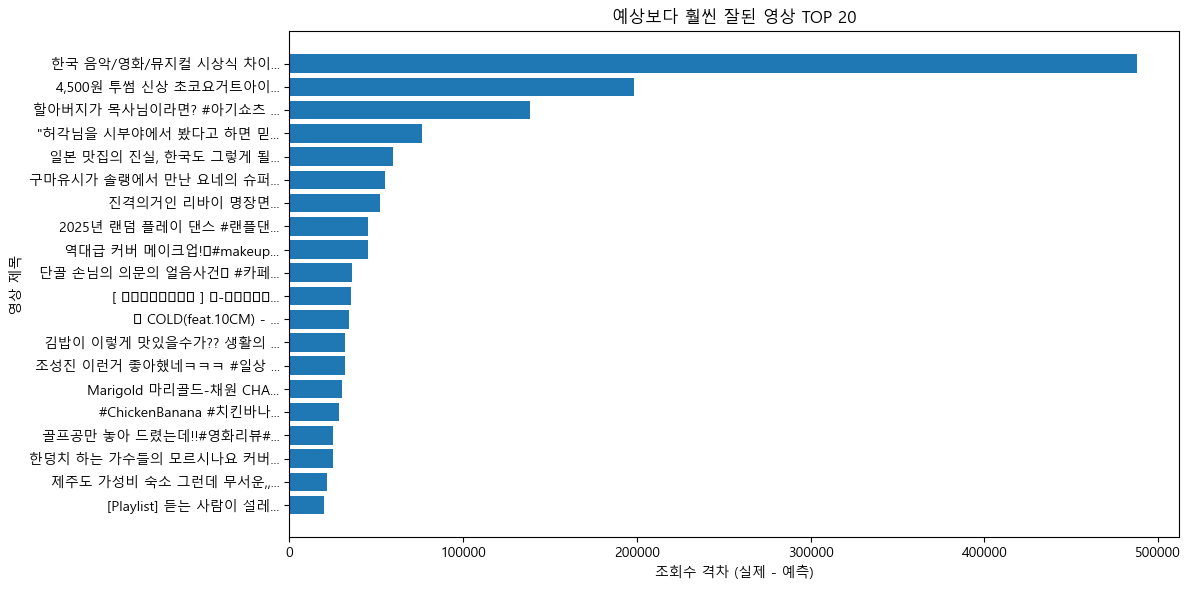

In [7]:

# gap 큰 상위 20개 추출
top_gap = final_df.sort_values(by='gap', ascending=False).head(20)

top_gap['short_title'] = top_gap['title'].str.slice(0, 20) + '...'

# 시각화
plt.figure(figsize=(12, 6))
plt.barh(top_gap['short_title'], top_gap['gap'])
plt.xlabel("조회수 격차 (실제 - 예측)")
plt.ylabel("영상 제목")
plt.title("예상보다 훨씬 잘된 영상 TOP 20")
plt.gca().invert_yaxis()  # gap 큰 게 위로 오게
plt.tight_layout()
plt.show()

In [8]:
# 1. gap 가장 큰 3개 영상 추출
top3_videos = final_df.sort_values(by='gap', ascending=False).head(3)

# 2. 해당 채널들의 이름 리스트
top3_channels = top3_videos['channelTitle'].unique()

# 3. 해당 채널의 모든 영상 필터링
top3_all_videos = final_df[final_df['channelTitle'].isin(top3_channels)]

# 4. 채널별 평균 gap 계산
channel_gap_stats = top3_all_videos.groupby('channelTitle')['gap'].agg(['mean', 'std']).reset_index()

# 5. top3 영상과 gap 평균 병합
top3_merged = pd.merge(top3_videos, channel_gap_stats, on='channelTitle')

# 6. gap 비율
top3_merged['gap_ratio'] = top3_merged['gap'] / (top3_merged['mean'] + 1)

# 결과 보기
top3_merged[['channelTitle', 'title', 'gap', 'mean', 'gap_ratio']]

,channelTitle,title,gap,mean,gap_ratio
0,뮤지컬을 먹고 사는 코레(MusicalKore),한국 음악/영화/뮤지컬 시상식 차이,487716.622150,487716.622150,0.999998
1,유미의맛슐랭,"4,500원 투썸 신상 초코요거트아이스크림 #투썸플레이스",198142.603856,198142.603856,0.999995
2,코별맘,할아버지가 목사님이라면? #아기쇼츠 #10개월아기 #크리스천연애와결혼,138683.099414,138683.099414,0.999993


In [9]:
# top3 채널의 ID 찾기
top3_channel_titles = top3_merged['channelTitle'].unique()
top3_channel_ids = merged_df[merged_df['channelTitle'].isin(top3_channel_titles)][['channelTitle', 'channelID']].drop_duplicates()

print(top3_channel_ids)

                     channelTitle                 channelID
34992  뮤지컬을 먹고 사는 코레(MusicalKore)  UCvODM8IJQhC68mbNyyckwPg
47144                         코별맘  UCxs2VeDUwqyVNw7mnQ3ppig
98629                      유미의맛슐랭  UCgSjYu0A4_u65BrLqXY2Y0g


In [11]:
import os
from dotenv import load_dotenv
from googleapiclient.discovery import build
import time

# .env 파일에서 API 키들 로드
load_dotenv()
api_keys = [os.getenv(f"API_KEY{i}") for i in range(1, 49)]

# API 초기화 함수
def get_youtube_service(api_key):
    return build('youtube', 'v3', developerKey=api_key)

# 현재 사용 중인 키 인덱스
current_key_index = 0
youtube = get_youtube_service(api_keys[current_key_index])

# API 호출 함수
def api_call(request_fn, **kwargs):
    global current_key_index, youtube
    max_tries = len(api_keys)

    for _ in range(max_tries):
        try:
            request = request_fn(**kwargs)
            response = request.execute()
            return response
        except Exception as e:
            print(f"[키 {current_key_index+1}] 오류 발생 → 다음 키로 교체: {e}")
            current_key_index += 1
            if current_key_index >= len(api_keys):
                raise RuntimeError("사용 가능한 API 키가 없습니다.")
            youtube = get_youtube_service(api_keys[current_key_index])
            time.sleep(1)

# 채널 ID → uploads 플레이리스트 ID 가져오기
def get_uploads_playlist_id(channel_id):
    response = api_call(
        youtube.channels().list,
        part="contentDetails",
        id=channel_id
    )
    return response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

# 채널 ID
channel_id = top3_channel_ids.iloc[0]['channelID']

# 업로드 리스트 ID 받아오기
uploads_playlist_id = get_uploads_playlist_id(channel_id)
print(f"업로드 playlist ID: {uploads_playlist_id}")

def get_all_video_ids_from_playlist(playlist_id, max_results=500):
    video_ids = []
    next_page_token = None
    total_fetched = 0

    while True:
        response = api_call(
            youtube.playlistItems().list,
            part="snippet",
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )

        items = response.get("items", [])
        for item in items:
            video_id = item['snippet']['resourceId']['videoId']
            video_ids.append(video_id)
            total_fetched += 1
            if total_fetched >= max_results:
                break

        next_page_token = response.get("nextPageToken")
        if not next_page_token or total_fetched >= max_results:
            break

    return video_ids

video_ids = get_all_video_ids_from_playlist(uploads_playlist_id)
print(f"수집된 영상 수: {len(video_ids)}개")
print(video_ids[:5])

def get_video_details(video_ids):
    all_video_data = []

    for i in range(0, len(video_ids), 50):
        batch_ids = video_ids[i:i+50]
        response = api_call(
            youtube.videos().list,
            part="snippet,statistics",
            id=",".join(batch_ids)
        )

        for item in response.get("items", []):
            video_data = {
                'videoId': item['id'],
                'title': item['snippet']['title'],
                'publishedAt': item['snippet']['publishedAt'],
                'viewCount': int(item['statistics'].get('viewCount', 0)),
                'likeCount': int(item['statistics'].get('likeCount', 0)),
                'commentCount': int(item['statistics'].get('commentCount', 0))
            }
            all_video_data.append(video_data)

    return pd.DataFrame(all_video_data)

video_df = get_video_details(video_ids)
print(f"수집된 영상 메타데이터: {len(video_df)}개")
video_df.head()

업로드 playlist ID: UUvODM8IJQhC68mbNyyckwPg
수집된 영상 수: 16개
['xUxpRuia5xU', 'QX-KfMWpNuk', 'cbas1uZiHSc', 'dNDyiKPa4cI', '4gVsfYSP8sI']
수집된 영상 메타데이터: 16개


,videoId,title,publishedAt,viewCount,likeCount,commentCount
0,xUxpRuia5xU,뮤지컬 배우들의 뒷담화,2025-03-25T11:05:39Z,5672,65,2
1,QX-KfMWpNuk,썸씽로튼 이거 들으러 간 사람,2025-03-24T11:22:16Z,510,7,0
2,cbas1uZiHSc,"사랑, 그리운 마음인데. 사랑, 그리운 사람인데.",2025-03-22T13:06:28Z,470,8,0
3,dNDyiKPa4cI,박규원 필살기 타임,2025-03-21T10:30:48Z,697,13,0
4,4gVsfYSP8sI,시라노 삭제 장면,2025-03-19T10:05:50Z,822,21,0


In [17]:
import seaborn as sns

all_video_dfs = []

for i in range(len(top3_channel_ids)):
    # 1. 채널 정보 추출
    channel_id = top3_channel_ids.iloc[i]['channelID']
    channel_title = top3_channel_ids.iloc[i]['channelTitle']

    # 2. 업로드 리스트 ID
    uploads_playlist_id = get_uploads_playlist_id(channel_id)

    # 3. 영상 ID 수집
    video_ids = get_all_video_ids_from_playlist(uploads_playlist_id)

    # 4. 영상 메타데이터 수집
    video_df = get_video_details(video_ids)

    # 5. 채널 정보 붙이기
    video_df['channelID'] = channel_id
    video_df['channelTitle'] = channel_title

    # 6. 누락 피처 채우기
    video_df['subscriberCount'] = 0
    video_df['videosCount'] = len(video_df)
    video_df['duration'] = 300
    video_df['categoryID'] = 0
    video_df['likeCount'] = video_df['likeCount'].fillna(0)
    video_df['commentCount'] = video_df['commentCount'].fillna(0)

    # 7. 예측
    X_new = video_df[features]
    y_pred_log = model.predict(X_new)
    y_pred = np.expm1(y_pred_log)

    video_df['predicted_viewCount'] = y_pred
    video_df['gap'] = video_df['viewCount'] - video_df['predicted_viewCount']
    video_df['gap_ratio'] = video_df['viewCount'] / (video_df['predicted_viewCount'] + 1)
    video_df['short_title'] = video_df['title'].str.slice(0, 30) + '...'

    # 8. 리스트에 저장
    all_video_dfs.append(video_df)

# 9. 모든 채널 영상 통합
combined_df = pd.concat(all_video_dfs, ignore_index=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_10060\3156286535.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='channelTitle', y='gap', palette='pastel')


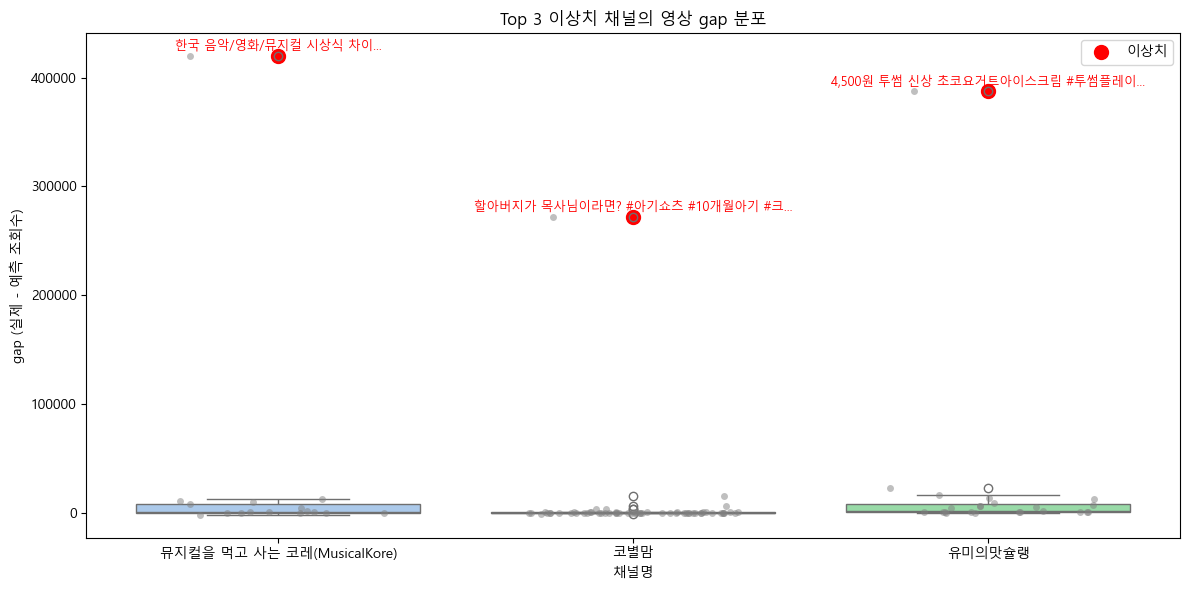

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_df, x='channelTitle', y='gap', palette='pastel')
sns.stripplot(data=combined_df, x='channelTitle', y='gap', color='gray', alpha=0.5, jitter=0.3)

# 이상치 영상 표시
for channel in combined_df['channelTitle'].unique():
    top = combined_df[combined_df['channelTitle'] == channel].sort_values(by='gap', ascending=False).iloc[0]
    xpos = list(combined_df['channelTitle'].unique()).index(channel)
    plt.scatter(xpos, top['gap'], color='red', s=100, label='이상치' if xpos == 0 else "")
    plt.text(xpos, top['gap'] + 5000, top['short_title'], ha='center', fontsize=9, color='red')

plt.title("Top 3 이상치 채널의 영상 gap 분포")
plt.ylabel("gap (실제 - 예측 조회수)")
plt.xlabel("채널명")
plt.legend()
plt.tight_layout()
plt.show()